#### FCN_VGG16_16s  
#### dataset: pascal voc 2012 segmentation(21分类)

need:
1. BilinearUpSampling.py 
2. [vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5](https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5)

#### 1. 建立模型

In [1]:
from keras.layers import *
from keras.regularizers import *
import os
from keras.models import Model
from BilinearUpSampling import *

def FCN_Vgg16_16s(input_shape=None, weight_decay=0., batch_momentum=0.9, batch_shape=None, classes=21):
    if batch_shape:
        img_input = Input(batch_shape=batch_shape)
        image_size = batch_shape[1:3]
    else:
        img_input = Input(shape=input_shape)
        image_size = input_shape[0:2]
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    #classifying layer
    o_4 = Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='linear', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Convolutional layers transfered from fully-connected layers
    x = Conv2D(512, (7, 7), activation='relu', padding='same', name='fc1', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(512, (1, 1), activation='relu', padding='same', name='fc2', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)


    #classifying layer
    x = Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='linear', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)

    x = BilinearUpSampling2D(size=(2, 2))(x)

    x=add([x,o_4])


    x=BilinearUpSampling2D(size=(16,16))(x)

    x=(Activation('softmax'))(x)
    model = Model(img_input, x)
    weights_path='./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

    model.load_weights(weights_path, by_name=True)
    return model

Using TensorFlow backend.


In [2]:
from keras import optimizers

model=FCN_Vgg16_16s(input_shape=(320,320,3),classes=21)
optimizer=optimizers.RMSprop(lr=1e-5)
# loss_fn=softmax_sparse_crossentropy_ignoring_last_label
# metrics=[sparse_accuracy_ignoring_last_label]
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc'])
# model.compile(loss=loss_fn,optimizer=optimizer,metrics=metrics)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 320, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 320, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 160, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

#### 2.处理数据，将mask转化为one_hot形式的向量

In [3]:
colormap = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
            [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
            [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128],
            [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0],
            [0, 192, 0], [128, 192, 0], [0, 64, 128]]
cm2lbl = np.zeros(256 ** 3)  # 每个像素点有 0 ~ 255 的选择，RGB 三个通道
for i, cm in enumerate(colormap):
    cm2lbl[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i  # 建立索引


def image2label(im):
    # 输入三维的mask图片，返回二维的矩阵，对每一个像素进行标记(320,320,3)->(320,320)
    #如[0,0,0]标记为0,[128,0,0]标记为1
    data = np.array(im, dtype='int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    return np.array(cm2lbl[idx], dtype='int64')


def adjustData(img, mask, num_class):
    # 将mask转换为one_hot形式(320,320)->(320,320,21)
    img, _ = img
    mask, _ = mask
    
    img = img / 255.
    mask_label = np.zeros(mask[:, :, :, 0].shape)
    # 将3通道的mask首先转换为二维的label
    for j in range(mask.shape[0]):
        mask_label[j] = image2label(mask[j])

    mask_one_hot = np.zeros(mask_label.shape + (num_class,))
    # 将二维的label转换为三维的one_hot形式
    for i in range(num_class):
        mask_one_hot[mask_label == i, i] = 1
    mask = mask_one_hot.astype('int32')

    return (img, mask)

#### 3. 模型训练
- 1.数据采用的是裁剪后的图片，不是通过原图resize的
- 2.在用到数据增强的时候，必须得注意要在flow_from_directory中传入相同的seed，这样才能保证mask和原图的像素点依然是对应的

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

checkpoint=ModelCheckpoint('./models/lab_02_fcn16s.hdf5',monitor='val_acc',save_best_only=True,verbose=1)
def train_generator(data_gen_args):
    train_images_datagen = ImageDataGenerator(**data_gen_args)
    train_masks_datagen = ImageDataGenerator(**data_gen_args)

    train_images_generator=train_images_datagen.flow_from_directory('./data/train',classes=['images'],class_mode='categorical',seed=1,target_size=(320,320),batch_size=20)
    train_tasks_generator=train_masks_datagen.flow_from_directory('./data/train',classes=['masks'],class_mode='categorical',seed=1,target_size=(320,320),batch_size=20)
    train_generator=zip(train_images_generator,train_tasks_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,21)
        yield (img,mask)

def val_generator():
    val_images_datagen = ImageDataGenerator()
    val_masks_datagen = ImageDataGenerator()

    val_images_generator=val_images_datagen.flow_from_directory('./data/validation',classes=['images'],class_mode='categorical',seed=1,target_size=(320,320),batch_size=20)
    val_tasks_generator=val_masks_datagen.flow_from_directory('./data/validation',classes=['masks'],class_mode='categorical',seed=1,target_size=(320,320),batch_size=20)
    val_generator=zip(val_images_generator,val_tasks_generator)
    for (img,mask) in val_generator:
        img,mask = adjustData(img,mask,21)
        yield (img,mask)
        
        
    
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    horizontal_flip=True,
                    fill_mode='constant',cval=0)
#若是想用数据增强，就把下一行注释掉
data_gen_args=dict()
train_generator = train_generator(data_gen_args)
val_generator=val_generator()
history=model.fit_generator(train_generator,steps_per_epoch=116,epochs=30,validation_data=val_generator,validation_steps=15,callbacks=[checkpoint])

Epoch 1/30
Found 290 images belonging to 1 classes.
Found 2330 images belonging to 1 classes.
Found 290 images belonging to 1 classes.
Found 2330 images belonging to 1 classes.
116/116 [==============================] - 86s 742ms/step - loss: 1.3965 - acc: 0.6934 - val_loss: 1.1010 - val_acc: 0.7143

Epoch 00001: val_acc improved from -inf to 0.71433, saving model to ./models/lab_02_fcn16s.hdf5
Epoch 2/30
116/116 [==============================] - 79s 685ms/step - loss: 1.0277 - acc: 0.7331 - val_loss: 0.9251 - val_acc: 0.7429

Epoch 00002: val_acc improved from 0.71433 to 0.74286, saving model to ./models/lab_02_fcn16s.hdf5
Epoch 3/30
116/116 [==============================] - 79s 683ms/step - loss: 0.8980 - acc: 0.7558 - val_loss: 0.8635 - val_acc: 0.7560

Epoch 00003: val_acc improved from 0.74286 to 0.75602, saving model to ./models/lab_02_fcn16s.hdf5
Epoch 4/30
116/116 [==============================] - 79s 680ms/step - loss: 0.8044 - acc: 0.7718 - val_loss: 0.7848 - val_acc: 0.77

#### 4.绘制acc,val_acc,loss，val_loss随着epochs的变化

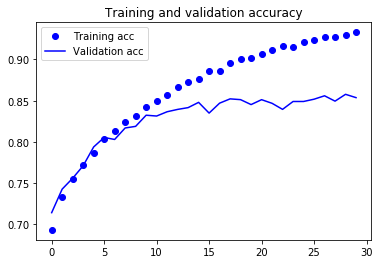

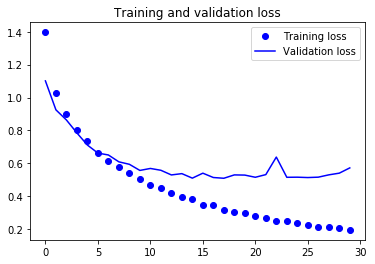

In [7]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()